# <center> SIAM CSE Poster

In [1]:
import numpy as np
import scipy.stats as ss
import scipy
from cbayes import sample, solve, distributions
import ipywidgets as wd
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 42})
plt.rcParams['figure.figsize'] = 20, 20
from mpl_toolkits.mplot3d import Axes3D


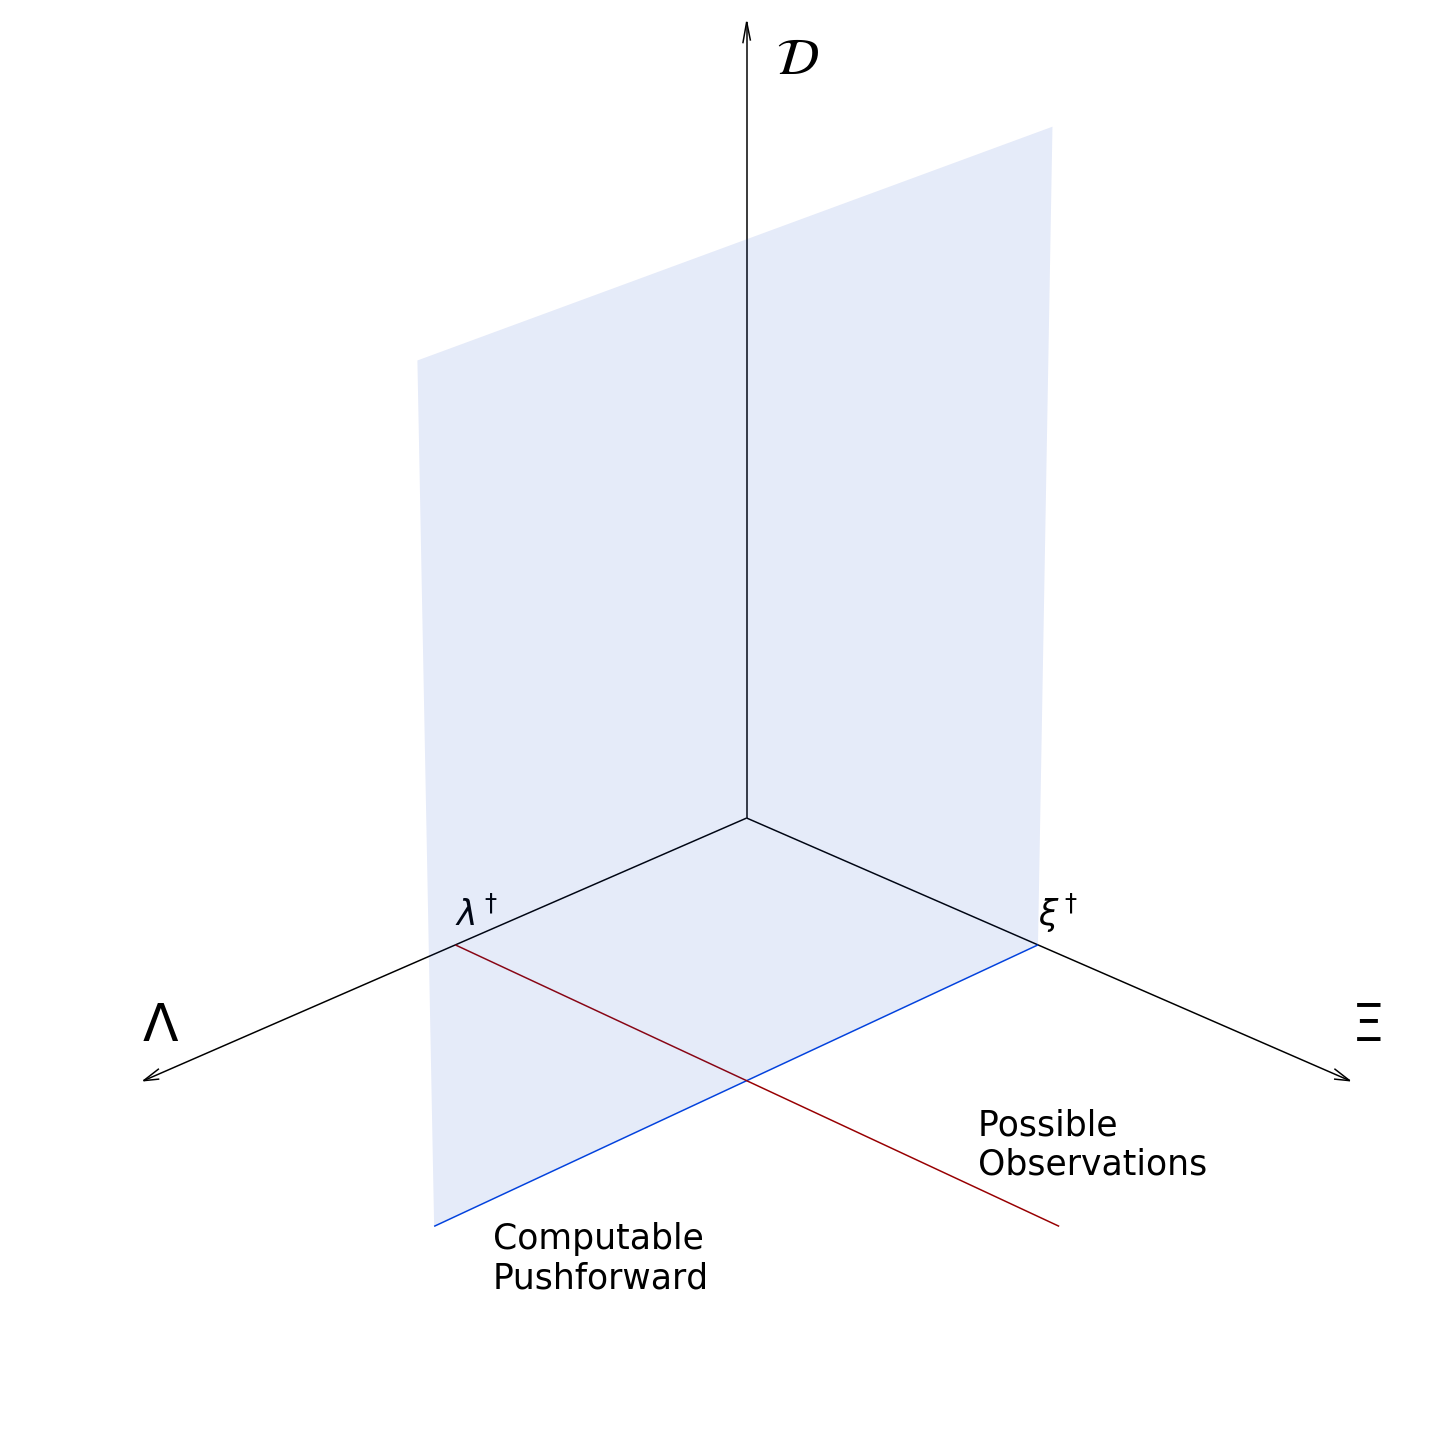

In [3]:
fig3d = plt.figure()
ax = fig3d.add_subplot(111, projection='3d')

# xx, zz = np.meshgrid(np.linspace(0,1,10), np.linspace(0,1,10))
# point = np.array([0.5, 0.5, 0.5])
# normal = np.array([0, 1, 0])
# d = -point.dot(normal)
# y = (-normal[0] * xx - normal[1] * zz - d)*1./normal[1]
# ax.plot_surface(xx, yy, z, alpha=0.2)

ax = plt.subplot(projection='3d')
ax.grid(False)
ax.axis('off')
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


fsize=52
ax.text(1,0,0.05, '$\\Lambda$', fontsize=fsize)
ax.text(0.5,0,0.025,'$\\lambda^\dagger$', fontsize=fsize/1.5)

ax.text(0,1,0.05, '$\\Xi$', fontsize=fsize)
ax.text(0,0.5,0.025,'$\\xi^\dagger$', fontsize=fsize/1.5)

ax.text(0,0.05,0.95, '$\\mathcal{D}$', fontsize=fsize)

x, y, z = np.zeros((3,3))
u, v, w = np.array([[1,0,0],[0,1,0],[0,0,1]])
ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.025, color='black')

xx, zz = np.meshgrid(range(2), range(2))
ax.plot_surface(xx, zz*0 + 0.5, zz, alpha = 0.10, color='xkcd:blue')
ax.quiver(0,0.5,0, 1,0,0, arrow_length_ratio=0, color='xkcd:blue')

ax.text(0.475,0.85,0, "Possible\nObservations", fontsize=fsize/1.5)
ax.text(1.05,0.65,0, "Computable\nPushforward", fontsize=fsize/1.5)
ax.quiver(0.5,0,0, 0,1,0, arrow_length_ratio=0, color='xkcd:blood red')

ax.view_init(25, 45)
ax.set_xlim3d([0,0.9])
ax.set_ylim3d([0,0.9])
ax.set_zlim3d([0,0.85])

plt.tight_layout(pad=0)
plt.savefig('diagram.png')
plt.show()

In [4]:
!mv diagram.png figures/

# <center> Example
## <center> Exponential Decay

In [5]:
lam_true = 0.5
def makeDecayModel(t):
    def model(lam = np.array([[lam_true]]) ):
#         rate = 0.5
#         initial_cond = lam[:,0].reshape(-1,1)
        initial_cond = 0.5
        try:
            rate = lam[:,0].reshape(-1,1)
        except TypeError: # overload input type for scipy.integrate.
            rate = lam
        response = initial_cond*np.exp(np.outer(rate, -t))
        if response.shape[0] == 1:
            return response.ravel() # this allows support for simpler 1D plotting.
        else:
            return response
    return model


In [6]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
start_time = 1
end_time = 3
sigma2 = 1E-3
sigma = np.sqrt(sigma2) # fixed noise level in the data
####

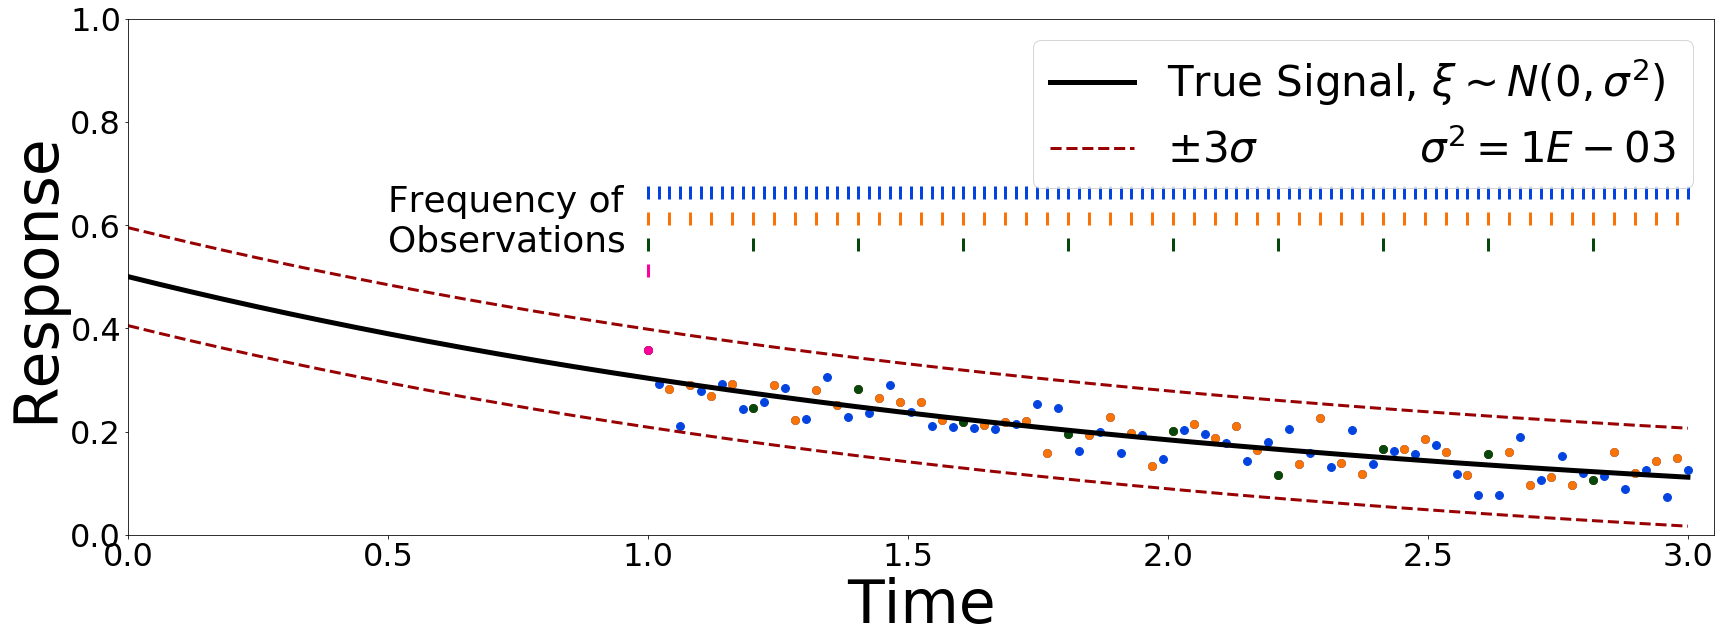

In [7]:
filename = 'exponential_decay_response' + '_sigma-%dE-4'%(sigma2*10000) + '.png'
plt.rcParams['figure.figsize'] = 25, 10
fig = plt.figure()

full_time = np.linspace(0, end_time, 1000)
full_model = makeDecayModel(full_time)
true_response = full_model() # no args evaluates true param

plt.plot(full_time, true_response, lw=5, c='k', alpha=1, label="True Signal, $\\xi \\sim N(0, \\sigma^2)$")
# plt.title("Exponential Decay\n")
plt.plot(full_time, true_response+3*sigma, ls='--', lw=3, c='xkcd:blood red', alpha=1)
plt.plot(full_time, true_response-3*sigma, ls='--', lw=3, c='xkcd:blood red', alpha=1, label="$\\pm3\\sigma \qquad\qquad \\sigma^2=%1.0E$"%(sigma**2))

# SET GLOBAL STYLES
marker_list = ['o', 'o', 'o', 'o']
marker_size = [50, 100, 150, 200]
colors = ['xkcd:neon pink', 'xkcd:forest green', 'xkcd:orange', 'xkcd:blue']
colors = colors[::-1]


t = np.linspace(start_time, end_time, 100)
model = makeDecayModel(t)
np.random.seed(11)
u = model() + np.random.randn(100)*sigma

for idx, num_obs in enumerate([1, 2, 10, 100]):
    col = colors[idx]
    start_ticks = 0.65
    tick_width = 0.025
    plt.vlines(t[0:100:(num_obs)], start_ticks-idx/20, start_ticks+tick_width-idx/20, color=col, lw=3)
    plt.scatter(t[0:100:(num_obs)], u[0:100:(num_obs)], color=col, marker='.', s=250, alpha=1)#, label="Data for $D=%d$"%(100/num_obs))
# plt.scatter(t, u, color='xkcd:blood red', s=250, alpha=0.75, marker='.')
# plt.scatter(t[0:100:10], u[0:100:10], color='xkcd:red', s=100, alpha=0.75, marker='.')
plt.annotate("Frequency of\nObservations",[0.5,0.55], fontsize=36)
plt.ylim([0,1])
plt.xlim([0,end_time+.05])
plt.ylabel('Response', fontsize=60)
plt.xlabel('Time', fontsize=60)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.legend()
plt.tight_layout()
plt.savefig(filename)
plt.show()

In [8]:
!mv exponential_decay_response*.png figures/

## Define Error Functional(s)

In [9]:
def error_function(model, obs_data, sigma=None, ftype='clt'):   # this generates a sum of squared residuals.
    def QoI_fun(inputs): # that conforms to our desired model input
        D = len(obs_data)
        predictions = model(inputs)
        assert predictions.shape[1] == D
        residuals = predictions - obs_data
        if ftype is 'clt':
            QoI = np.sqrt(1./D)*np.sum( residuals/sigma, axis=1 )  # CLT
        elif ftype is 'mse':
            if sigma is not None:
                QoI = (1./D)*np.sum( (residuals/sigma)**2, axis=1 )   # MSE
            else:
                QoI = (1./D)*np.sum( (residuals/obs_data)**2, axis=1 )  # MRSE
        elif ftype is 'sse':
            QoI = np.sum( (residuals/sigma)**2, axis=1 )  # SSR
        return QoI
    
    return QoI_fun

# <center> Convergence

In [10]:
num_samples = N = int(1E3) # number of input samples (N)
err_fun_type = 'clt'
input_dim = 1

# lam_mesh = np.linspace(0,1,1000).reshape(-1,1)
lam_mesh = np.linspace(0.4, 0.6, 500).reshape(-1,1)

np.random.seed(21)

s_set = sample.sample_set(size=(num_samples, input_dim))
# DEFINE DISTRIBUTIONS
s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 1}, dim=0) # initial condition
# s_set.set_dist('norm', kwds={'loc': 0, 'scale': sigma}, dim=1) # noise
s_set.generate_samples()
input_samples = s_set.samples # create a pointer for ease of reference later with plotting.
in_dist = s_set.dist
in_pdf = in_dist.pdf(lam_mesh)

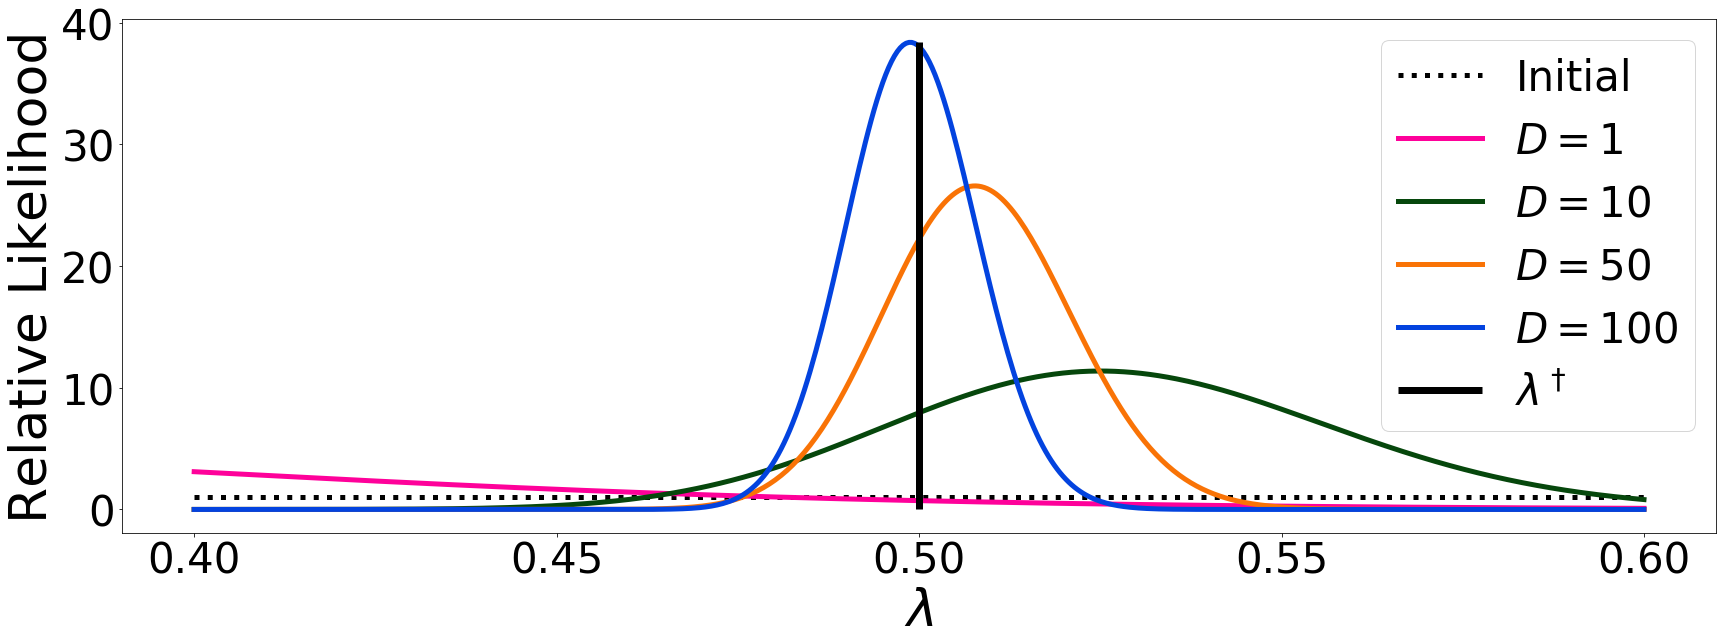

In [11]:
np.random.seed(11)
plt.rcParams['figure.figsize'] = 25, 10
fig = plt.figure()
ax = plt.gca()
ax.plot(lam_mesh, in_pdf, label="Initial", color='xkcd:black', ls=':', lw=5)
noise_vector = np.random.randn(int(100))*sigma

for idx,num_observations in enumerate([1,10,50,100]):
    
    t = np.linspace(start_time, end_time, num_observations)
    exponential_decay_model = makeDecayModel(t)
    u_true = exponential_decay_model() # evaluate model at truth


    observed_data = u_true + noise_vector[0:num_observations]
    QoI_fun = error_function(exponential_decay_model, observed_data, sigma=sigma, ftype=err_fun_type)

    p_set = sample.map_samples_and_create_problem(s_set, QoI_fun)
    output_samples = p_set.output.samples # handle for convenience

    ## Compute Predicted Distribution
    # (The Predicted Measure is the push-forward of the Initial Measure under the map $Q$)
    p_set.compute_pushforward_dist()
    pr_dist = p_set.pushforward_dist # handle for convenience

    ## Pick Appropriate Observed Distribution
    if err_fun_type is 'clt':
        p_set.set_observed_dist('normal', {'loc': 0, 'scale': 1}, dim=0)
    elif err_fun_type is 'mse':
        p_set.set_observed_dist('gamma', {'a':num_observations/2, 'scale':2/num_observations}, dim=0)
    elif err_fun is 'sse':
        p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)

    ob_dist = p_set.observed_dist # this is define a pointer for ease of reference.

    ## Solve Problem
    p_set.set_ratio()
    eta_r = p_set.ratio
#     s_set.seed = 11
#     solve.problem(p_set)


    post_eval = p_set.evaluate_posterior(lam_mesh)
    in_pdf = in_dist.pdf(lam_mesh)

    ax.plot(lam_mesh, post_eval, label="$D=%d$"%num_observations, color=colors[3-idx], lw=5)

ax.vlines(0.5, 0, np.max(post_eval), label="$\\lambda^\dagger$", lw=7, alpha=1, zorder=3)
plt.xlabel("$\\lambda$", fontsize=52)
plt.ylabel("Relative Likelihood", fontsize=52)
# plt.xlim([0.4, 0.6])
# plt.xlim([0.25, 0.75])
# plt.ylim([0,120])
ax.set_xticks([.4, .45, .5, .55, .6])
# ax.set_xticklabels([.4, .45, .5, .55, .6])
plt.legend()
plt.tight_layout()
plt.savefig('updated_convergence' + '_sigma-%dE-4'%(sigma2*10000) + '.png')
plt.show()


In [12]:
!mv updated_convergence*.png figures/

# <center> Stability

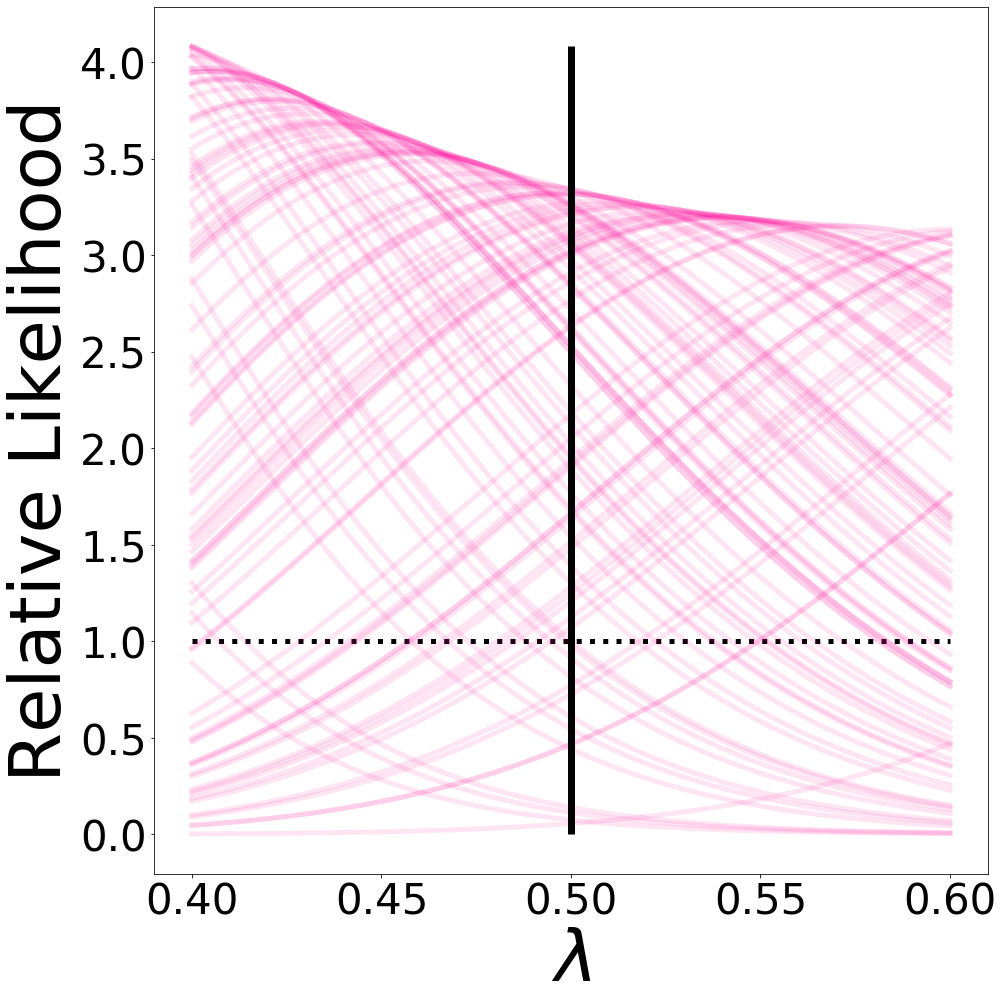

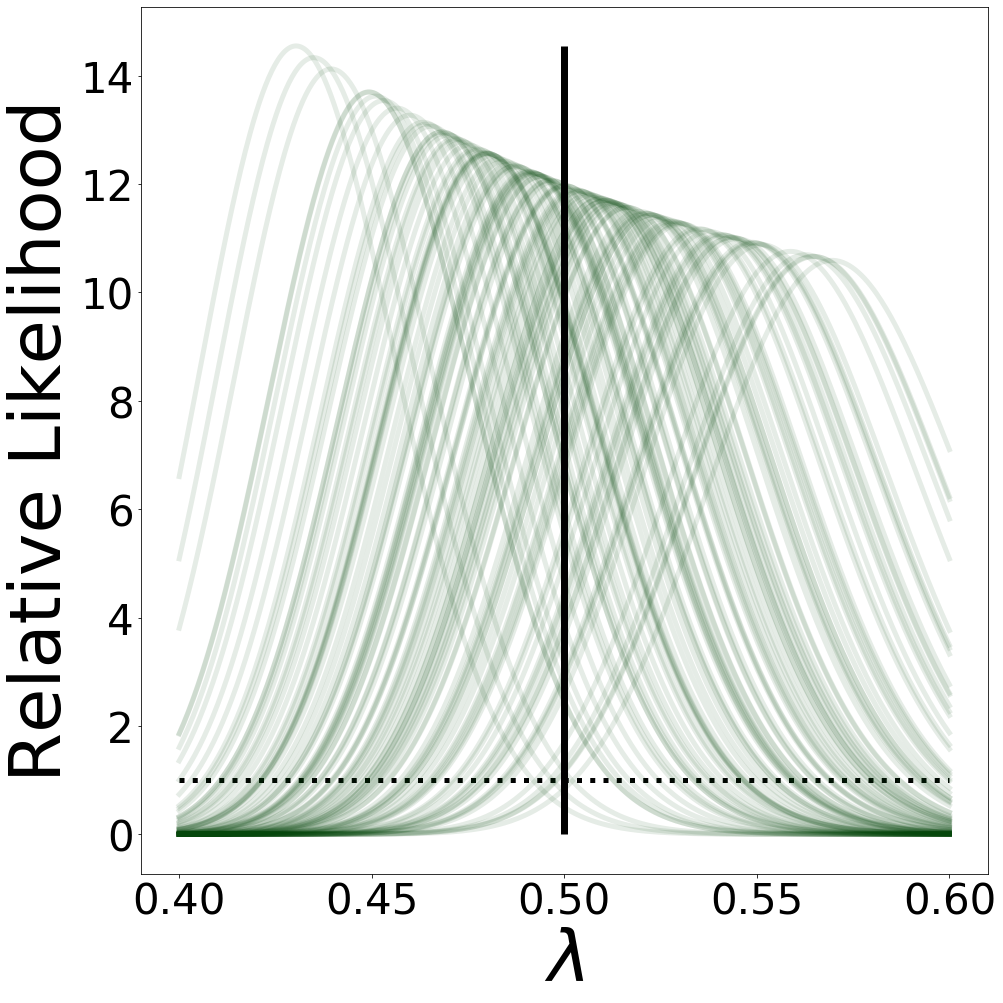

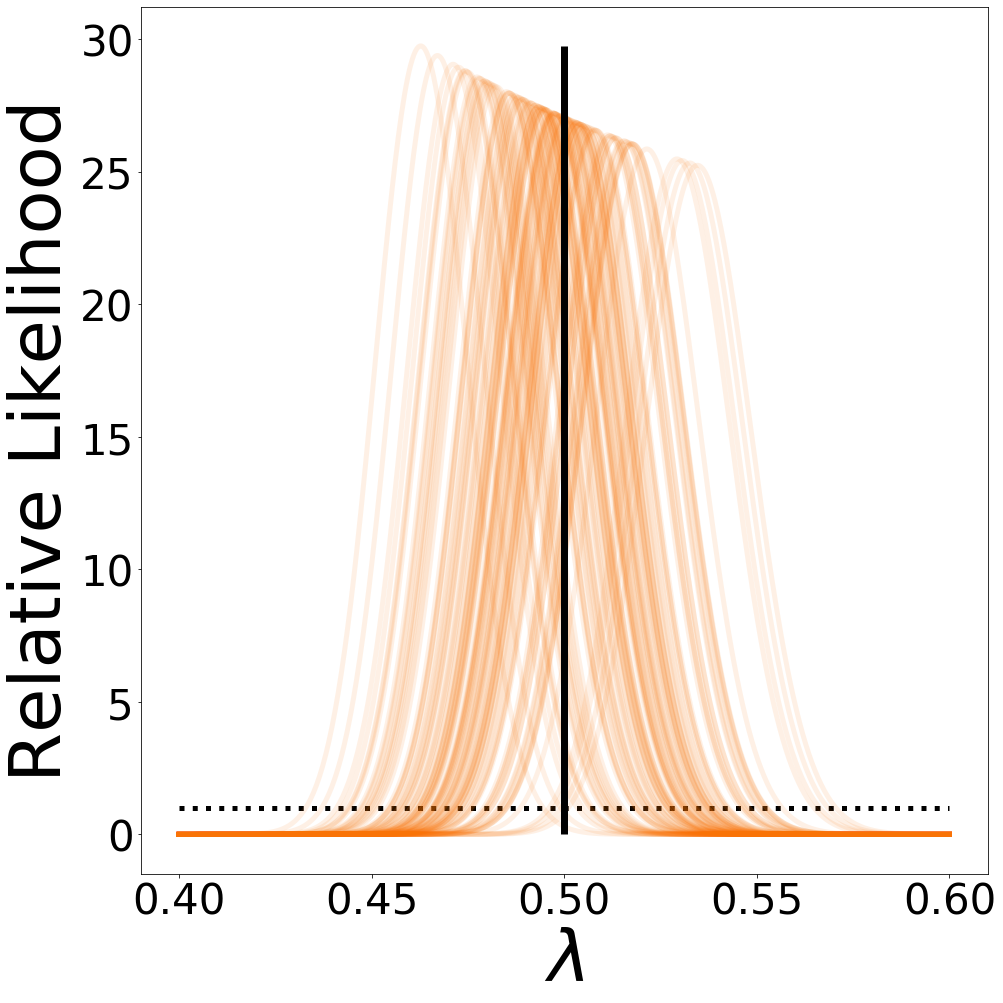

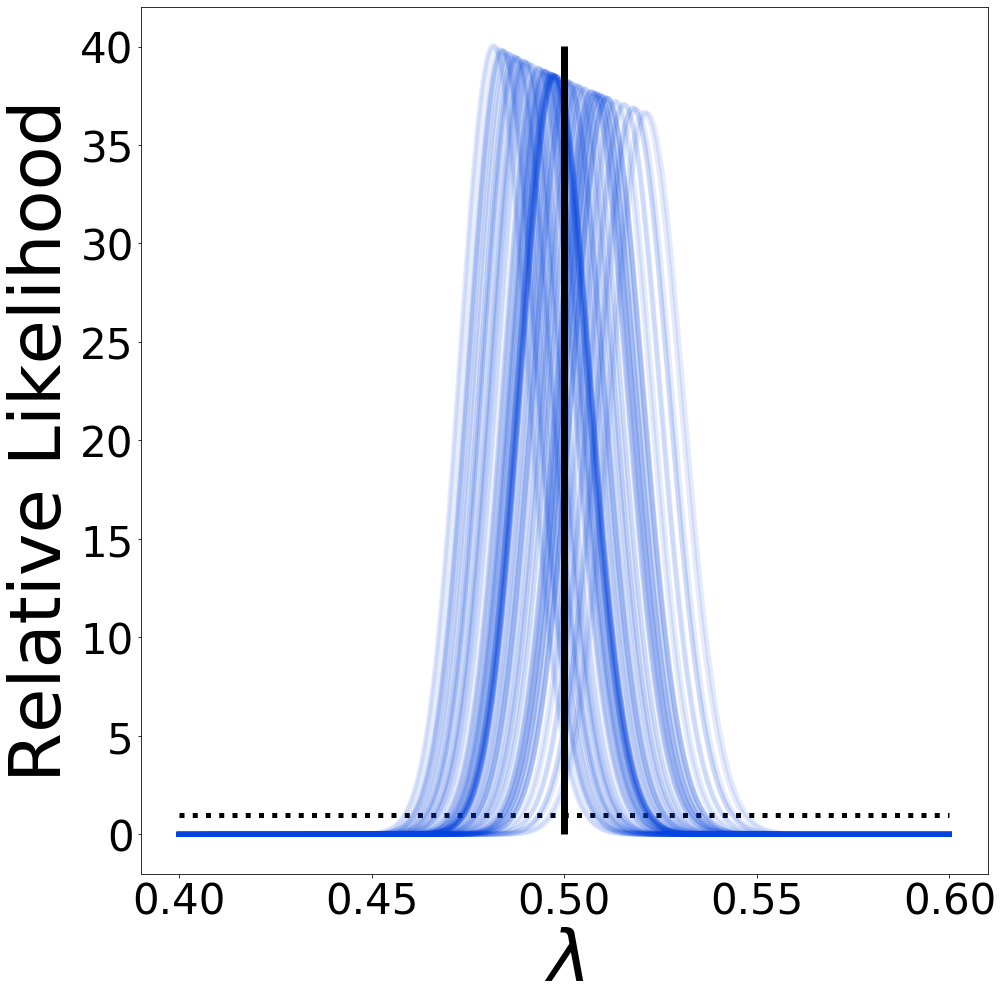

In [13]:
num_repeats = 100
np.random.seed(21)
plt.rcParams['figure.figsize'] = 15, 15
for idx,num_observations in enumerate([1,10,50,100]):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(lam_mesh, in_pdf, label="Initial", color='xkcd:black', ls=':', lw=5)
    max_ht = 0
    for i in range(num_repeats):
    #     different noise each time
        noise_vector = np.random.randn(num_observations)*sigma

        t = np.linspace(start_time, end_time, num_observations)
        exponential_decay_model = makeDecayModel(t)
        u_true = exponential_decay_model() # evaluate model at truth


        observed_data = u_true + noise_vector
        QoI_fun = error_function(exponential_decay_model, observed_data, sigma=sigma, ftype=err_fun_type)

        p_set = sample.map_samples_and_create_problem(s_set, QoI_fun)
        output_samples = p_set.output.samples # handle for convenience

        ## Compute Predicted Distribution
        # (The Predicted Measure is the push-forward of the Initial Measure under the map $Q$)
        p_set.compute_pushforward_dist()
        pr_dist = p_set.pushforward_dist # handle for convenience

        ## Pick Appropriate Observed Distribution
        if err_fun_type is 'clt':
            p_set.set_observed_dist('normal', {'loc': 0, 'scale': 1}, dim=0)
        elif err_fun_type is 'mse':
            p_set.set_observed_dist('gamma', {'a':num_observations/2, 'scale':2/num_observations}, dim=0)
        elif err_fun is 'sse':
            p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)

        ob_dist = p_set.observed_dist # this is define a pointer for ease of reference.

        ## Solve Problem
        p_set.set_ratio()
        eta_r = p_set.ratio


        post_eval = p_set.evaluate_posterior(lam_mesh)
        in_pdf = in_dist.pdf(lam_mesh)
        if i == 0:
            ax.plot(lam_mesh, post_eval, color=colors[3-idx], label='$D=%d$'%num_observations, lw=5, alpha=0.1)
        else:
            ax.plot(lam_mesh, post_eval, color=colors[3-idx], lw=5, alpha=0.1)
        max_ht = np.max([np.max(post_eval), max_ht])

    ax.vlines(0.5, 0, max_ht, label="$\\lambda^\dagger$", lw=7, alpha=1, zorder=3)
    lsize=72
    plt.xlabel("$\\lambda$", fontsize=lsize)
    plt.ylabel("Relative Likelihood", fontsize=lsize)
    # plt.xlim([0.4, 0.6])
    # plt.xlim([0.25, 0.75])
    # plt.ylim([0,120])
#     plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('updated_stability_D%d'%num_observations + '_sigma-%dE-4'%(sigma2*10000) + '.png')
    plt.show()


In [14]:
!mv updated_stability*.png figures/

Note:
Interestingly, when inferring for _rate_ rather than initial condition, there isn't a symmetry in the behavior of the updated densities (in the stability results) to the left/right of the true value. The higher the rate ($\lambda$), the lower the peak of the distribution, i.e. the more uncertainty. This makes sense. If our signal was constant through time, we would have more confidence in our ability to infer the rate, since measurements at any point in time are equivalent. Higher rate = higher sensitivity = more precision.  

# <center> Likelihood </center>

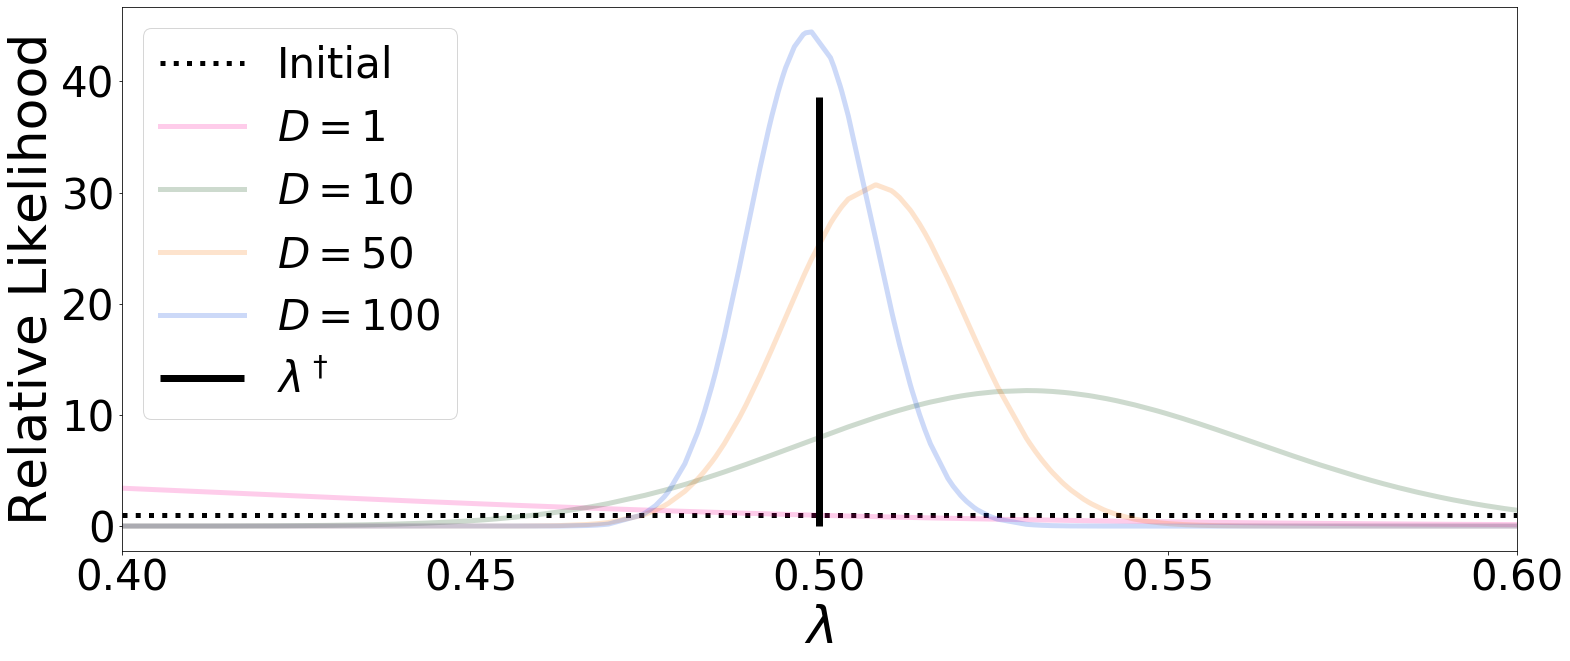

In [15]:
plt.rcParams['figure.figsize'] = 25, 10
fig = plt.figure()
ax = plt.gca()
ax.plot(lam_mesh, in_pdf, label="Initial", color='xkcd:black', ls=':', lw=5)

for idx, num_obs in enumerate([1, 10, 50, 100]):
    D = distributions.parametric_dist(num_obs)
    for i in range(num_obs):
        D.assign_dist('norm', dim = i, kwds={'loc': u[i], 'scale': sigma})
    output_samples = model(input_samples)
    outs = output_samples[:,:num_obs]
    evidence = scipy.integrate.quad(lambda x: D.pdf(model(x)[:num_obs].reshape(1,-1)),
                                    -1, 1)[0]
    likelihood = D.pdf(outs)
    asr = np.argsort(input_samples[:,0])
    sorted_inputs = input_samples[asr]
    sorted_outputs = likelihood[asr]*in_dist.pdf(input_samples)[asr]
    ax.plot(sorted_inputs, sorted_outputs/evidence, alpha = 0.2, 
            label="$D=%d$"%num_obs, c= colors[3-idx], lw=5)
            
ax.vlines(0.5, 0, np.max(post_eval), label="$\\lambda^\dagger$", lw=7, alpha=1, zorder=3)
plt.xlim([0.4, 0.6])
plt.xlabel("$\\lambda$", fontsize=52)
plt.ylabel("Relative Likelihood", fontsize=52)
ax.set_xticks([.4, .45, .5, .55, .6])
plt.legend()
plt.show()

Note:
Very interesting that qualitatively, we see the same ordering of the solutions. They appear to move/evolve the same way as more data becomes available. 

In [ ]:
num_repeats = 100
np.random.seed(21)
plt.rcParams['figure.figsize'] = 15, 15
for idx, num_observations in enumerate([1,10,50,100]):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(lam_mesh, in_pdf, label="Initial", color='xkcd:black', ls=':', lw=5)
    max_ht = 0
    for i in range(num_repeats):
    #     different noise each time
        noise_vector = np.random.randn(num_observations)*sigma

        t = np.linspace(start_time, end_time, num_observations)
        exponential_decay_model = makeDecayModel(t)
        u_true = exponential_decay_model() # evaluate model at truth

        observed_data = u_true + noise_vector
        
        D = distributions.parametric_dist(num_observations)
        for i in range(num_observations):
            D.assign_dist('norm', dim = i,
                          kwds={'loc': observed_data[i],
                                'scale': sigma})
        
        evidence = scipy.integrate.quad(lambda x: D.pdf(exponential_decay_model(x)[:num_observations].reshape(1,-1)),
                                        -1, 1)[0]
        outs = exponential_decay_model(lam_mesh)
        likelihood = D.pdf(outs)

        in_pdf = in_dist.pdf(lam_mesh)
        post_eval = in_pdf*likelihood/evidence
        if i == 0:
            ax.plot(lam_mesh, post_eval, color=colors[3-idx], label='$D=%d$'%num_observations, lw=5, alpha=0.1)
        else:
            ax.plot(lam_mesh, post_eval, color=colors[3-idx], lw=5, alpha=0.1)
        max_ht = np.max([np.max(post_eval), max_ht])

    ax.vlines(0.5, 0, max_ht, label="$\\lambda^\dagger$", lw=7, alpha=1, zorder=3)
    lsize=72
    plt.xlabel("$\\lambda$", fontsize=lsize)
    plt.ylabel("Relative Likelihood", fontsize=lsize)
    # plt.xlim([0.4, 0.6])
    # plt.xlim([0.25, 0.75])
    # plt.ylim([0,120])
#     plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('posterior_stability_D%d'%num_observations + '_sigma-%dE-4'%(sigma2*10000) + '.png')
    plt.show()


Note: Does not seem to be substantive differences between using a likelihood and an updated. One notable difference is visible in the scaling of the y-axis, which implies that on average, the Bayesian posterior is more confident in its solutions. 

## TO DO
- Make the posterior plot pretty/match formatting 
    - perform (quick) study of stability/convergence for posterior as well.
    - may or may not use this.
    - figure out proper normalization. currently "faking" it. use scipy(?) to integrate "evidence" (denominator of bayesian posterior) to properly normalize the posterior.
- Distrbutions problem